In [99]:
#!/usr/bin/python3.6
# -*- coding: utf-8 -*-

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import sklearn
import math
import os
import sys
import time
from datetime import datetime
import cv2

from keras import backend as K
plt.rcParams['font.family']='sans-serif'
plt.rcParams['font.sans-serif']=['SimHei'] #显示中文标签

from tensorflow import keras
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

Using TensorFlow backend.


In [2]:
from cigarcabinclassify.classifier import CategoricalClassifier, SparseClassifier, ResnetClassifier

In [188]:
model1 = load_model("cigar_model_1.h5")

In [264]:
model = keras.models.Sequential(model1.layers[:19])
img_path = '/opt/tv/all/004.jpg'

In [265]:
sample = cv2.imread(img_path)
sample = cv2.resize(sample, (128, 128))
sample_tf = np.expand_dims(sample,axis=0).astype('float32')/127.5-1
sample_tf = tf.Variable(sample_tf)

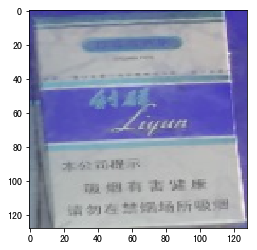

In [266]:
plt.imshow(sample)

In [267]:
cls = np.argmax(model1(sample_tf))

In [268]:
activations = model(sample_tf)

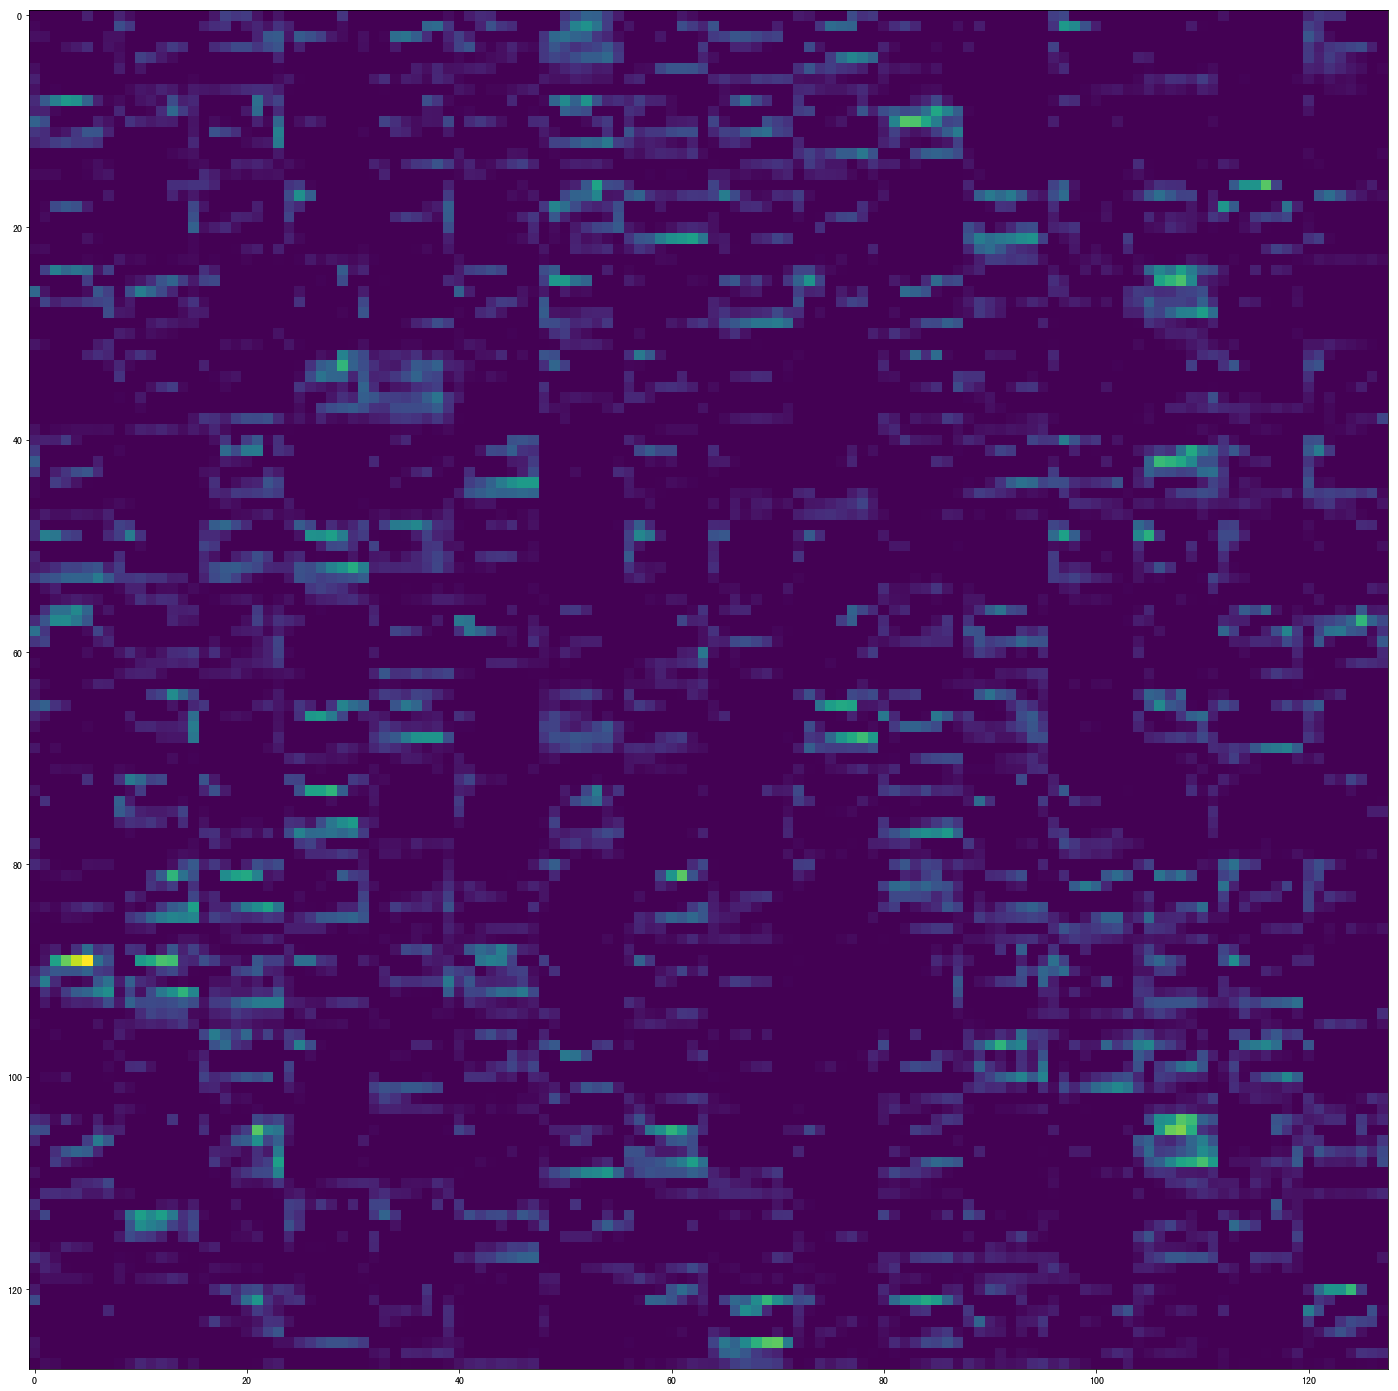

In [269]:
h = activations.shape[1]
w = activations.shape[2]
num_channels = activations.shape[3]

cols = 16
rows = math.ceil(num_channels/cols)
img_grid = np.zeros((h*rows,w*cols))

for c in range(num_channels):
    f_r = math.ceil((c+1)/cols)
    f_c = (c+1)if f_r==1 else (c+1-(f_r-1)*cols)
    img_grid[(f_r-1)*h:f_r*h,(f_c-1)*w:f_c*w ] = activations[0,:,:,c]


plt.figure(figsize=(25,25))
plt.imshow(img_grid, aspect='equal',cmap='viridis')
plt.grid(False)
plt.show()

In [270]:
bs_output = model1.output[:, cls]

In [271]:
last_conv_layer = model1.get_layer('conv2d_7')

In [272]:
k = K.gradients(bs_output, last_conv_layer.output)
grads = K.gradients(bs_output, last_conv_layer.output)[0]
pooled_grads = K.mean(grads, axis=(0, 1, 2))
iterate = K.function([model1.input], [pooled_grads, last_conv_layer.output[0]])
pooled_grads_value, conv_layer_output_value = iterate([sample_tf])
# We multiply each channel in the feature map array
# by "how important this channel is" with regard to the elephant class
for i in range(128):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

# The channel-wise mean of the resulting feature map
# is our heatmap of class activation
heatmap = np.mean(conv_layer_output_value, axis=-1)

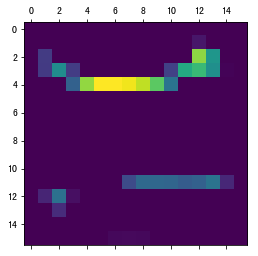

In [273]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)
plt.show()

In [274]:
import cv2

# We use cv2 to load the original image
img = cv2.imread(img_path)

# We resize the heatmap to have the same size as the original image
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

# We convert the heatmap to RGB
heatmap = np.uint8(255 * heatmap)

# We apply the heatmap to the original image
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

# 0.4 here is a heatmap intensity factor
superimposed_img = heatmap * 0.4 + img

# Save the image to disk
cv2.imwrite('cig.jpg', superimposed_img)

True

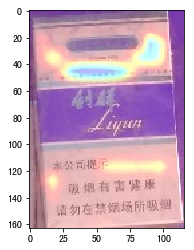

In [275]:
img = cv2.imread('cig.jpg')
plt.imshow(img)